In [1]:
# Import necessary libraries
import os
import sys
import argparse
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from model import CombinedModel    
from datasets import get_data_loaders, compute_mean_and_std
from train import train
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Training script test')
    parser.add_argument('--learning_rate', type=float, default=1e-3, help='Learning rate for the optimizer')
    parser.add_argument('--checkpoint_dir', type=str, default='./checkpoints', help='Directory to save checkpoints')
    parser.add_argument('--log_dir', type=str, default='./logs', help='Directory for TensorBoard logs')
    parser.add_argument('--train_dir', type=str, default='D:/sp_cup/dataset/train', help='Directory for training data')
    parser.add_argument('--test_dir', type=str, default='D:/sp_cup/dataset//valid', help='Directory for testing data')
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
    parser.add_argument('--epochs', type=int, default=2, help='Number of epochs to train')
    
    # Use parse_known_args to avoid errors
    args, unknown = parser.parse_known_args()
    return args


args = parse_args()

os.makedirs(args.checkpoint_dir, exist_ok=True)
os.makedirs(args.log_dir, exist_ok=True)

print(args)


Namespace(learning_rate=0.001, checkpoint_dir='./checkpoints', log_dir='./logs', train_dir='D:/sp_cup/dataset/train', test_dir='D:/sp_cup/dataset//valid', batch_size=32, epochs=2)


### Model                                

In [3]:
class FrequencyBranch(nn.Module):
    def __init__(self, output_size=128, hidden_size1=512, hidden_size2=256):
        super(FrequencyBranch, self).__init__()
        # Recalculate input size for single sample (without batch dimension)
        input_size = 3 * 128 * 128 * 2  # 128x128 pixels, 2 features (amplitude and phase)
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, img):
        # img shape: [batch_size, channels, height, width]
        batch_size = img.shape[0]
        
        # Move to CPU for numpy operations
        img_np = img.cpu().numpy()
        
        # Process each image in the batch
        batch_features = []
        for i in range(batch_size):
            # Apply FFT to single image
            f_transform = np.fft.fft2(img_np[i])
            f_transform_shifted = np.fft.fftshift(f_transform)
            amplitude = np.abs(f_transform_shifted)
            phase = np.angle(f_transform_shifted)
            
            # Concatenate amplitude and phase
            features = np.concatenate((amplitude.flatten(), phase.flatten()))
            batch_features.append(features)
            
        # Stack all features into a batch
        batch_features = np.stack(batch_features)
        
        # Convert back to tensor
        input_tensor = torch.tensor(batch_features, dtype=torch.float32, device=img.device)
        # Pass through network
        x = self.relu(self.fc1(input_tensor))
        x = self.relu(self.fc2(x))
        output_vector = self.fc3(x)
        
        # output_vector shape will be [batch_size, output_size]
        return output_vector



In [4]:
class ConvBranch(nn.Module):
    def __init__(self, input_channels=3, output_features=128):
        super(ConvBranch, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.3)
            )
        self.model = nn.Sequential(
            conv_block(input_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, output_features),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, image):
        return self.model(image)

In [5]:
   
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.freq_branch = FrequencyBranch(output_size=128)
        self.conv_branch = ConvBranch(output_features=128)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Same input for both branches
        freq_output = self.freq_branch(x)
        conv_output = self.conv_branch(x)

        combined = torch.cat((freq_output, conv_output), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
def visualize_fft(image):
    """Plot the original image, magnitude spectrum and phase spectrum"""

    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude = np.abs(f_transform_shifted)
    phase = np.angle(f_transform_shifted)
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(np.log1p(magnitude), cmap='gray')
    ax[1].set_title('Magnitude Spectrum')
    ax[1].axis('off')
    
    ax[2].imshow(phase, cmap='gray')
    ax[2].set_title('Phase Spectrum')
    ax[2].axis('off')
    
    plt.show()

In [7]:
import os
import torch
from torch.utils.data import Dataset as TorchDataset
from imageio import imread
from torchvision import datasets, transforms
from tqdm import tqdm
import multiprocessing
from PIL import Image
from skimage.io import imread

In [8]:
class Dataset(TorchDataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = imread(self.image_paths[idx])
        label = self.labels[idx]

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label

In [9]:
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)
    print(f"Class names: {class_names}")    
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    print(f"Class to index: {class_to_idx}")
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_to_idx[class_name])
    return image_paths, labels


def get_data_loaders(train_dir, test_dir, batch_size, transform=None):
    train_image_paths, train_labels = get_image_paths_and_labels(train_dir)
    test_image_paths, test_labels = get_image_paths_and_labels(test_dir)

    train_dataset = Dataset(train_image_paths, train_labels, transform)
    test_dataset = Dataset(test_image_paths, test_labels, transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# Compute mean and std of the dataset
def compute_mean_and_std(data_dir):
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """

    cache_file = "mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    ds = datasets.ImageFolder(
        data_dir, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=multiprocessing.cpu_count()
    )

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std



In [10]:
print("Initializing Model")
model = CombinedModel()


# print(model)

Initializing Model


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
model = model.to(device)

device: cuda


In [12]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

# print(criterion, optimizer)

In [13]:
# Load datasets
dataset_mean, dataset_std = compute_mean_and_std(args.train_dir)
print(f"Mean: {dataset_mean}, Std: {dataset_std}")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.3996, 0.3194, 0.3223], [0.2321, 0.1766, 0.1816])
])
train_loader, valid_loader = get_data_loaders(args.train_dir, args.test_dir, args.batch_size, transform)

Computing mean:   0%|                                | 0/262160 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [27]:
print(torch.Tensor.tolist(dataset_mean))
print(torch.Tensor.tolist(dataset_std))

[0.4577801823616028, 0.3923501670360565, 0.37724995613098145]
[0.2649841904640198, 0.23986703157424927, 0.2503381669521332]


In [14]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.4577801823616028, 0.3923501670360565, 0.37724995613098145], [0.2649841904640198, 0.23986703157424927, 0.2503381669521332])
])
train_loader, valid_loader = get_data_loaders(args.train_dir, args.test_dir, args.batch_size, transform)

Class names: ['fake', 'real']
Class to index: {'fake': 0, 'real': 1}
Class names: ['fake', 'real']
Class to index: {'fake': 0, 'real': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7275754..1.6504358].


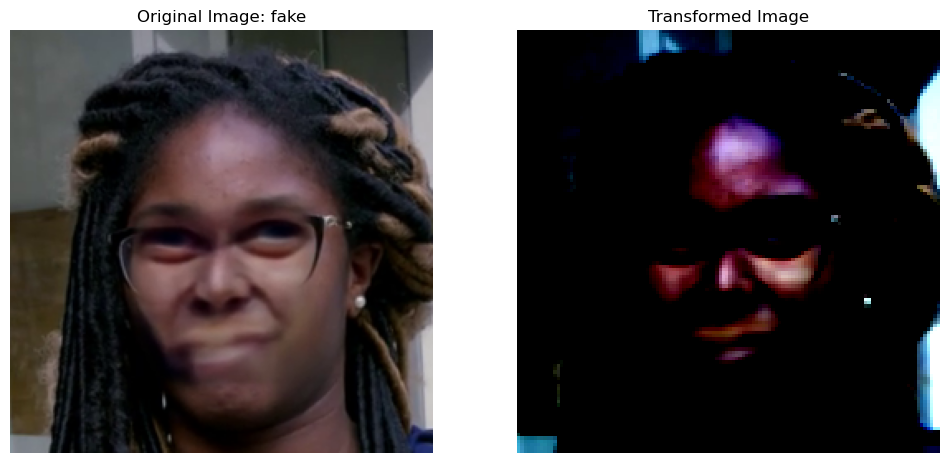

In [15]:
import random

# Get a random image and its label from the dataset
dataset = train_loader.dataset
random_idx = random.randint(0, len(dataset) - 1)
image_path = dataset.image_paths[random_idx]
label = dataset.labels[random_idx]

# Load the original image
original_image = Image.open(image_path)

# Apply the transformation
transformed_image = transform(original_image)

# Convert the transformed image to numpy array for plotting
transformed_image_np = transformed_image.permute(1, 2, 0).numpy()

# Plot the original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(original_image)
ax[0].set_title(f'Original Image: {"fake" if label == 0 else "real"}')
ax[0].axis('off')

ax[1].imshow(transformed_image_np)
ax[1].set_title('Transformed Image')
ax[1].axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.99272267939164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.141582499884479..3.141592653589793].


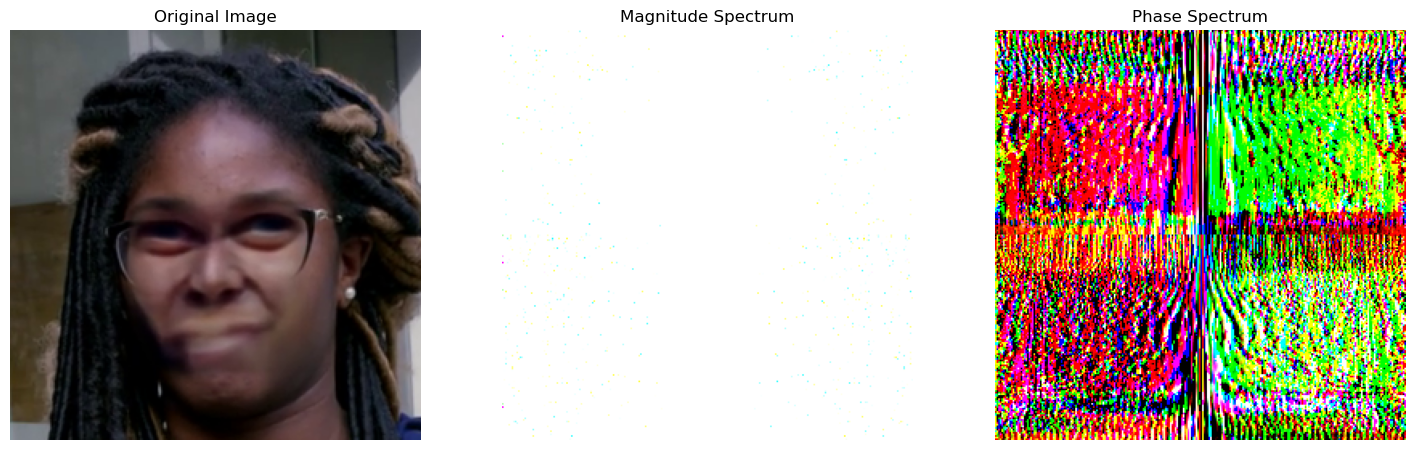

In [16]:
visualize_fft(original_image)

In [17]:
print(original_image.size)

(256, 256)


1
1
1
1
1


In [3]:
print(next(iter(list_1)))

1
